In [2]:
import numpy as np
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
image_folder_path = "/kaggle/input/isci-cgan-dataset/Dataset/Train/Train_data"

Found image: ISIC_0030912.jpg


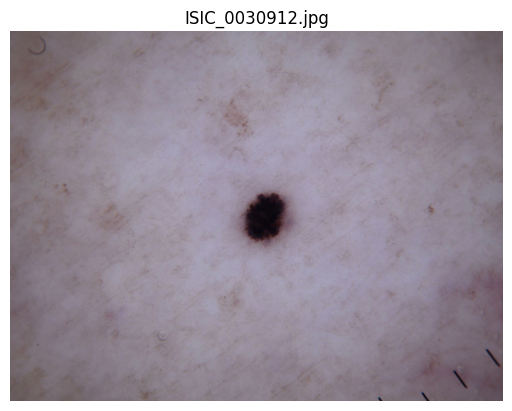

Found image: ISIC_0028933.jpg


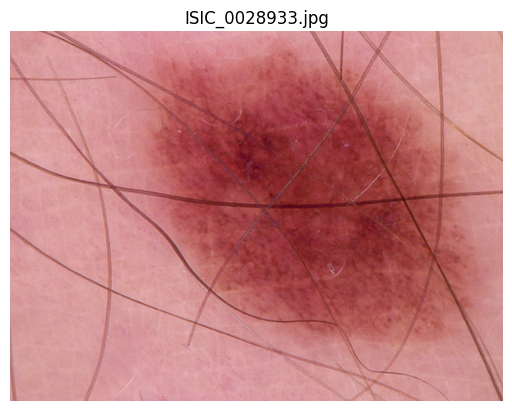

Found image: ISIC_0030585.jpg


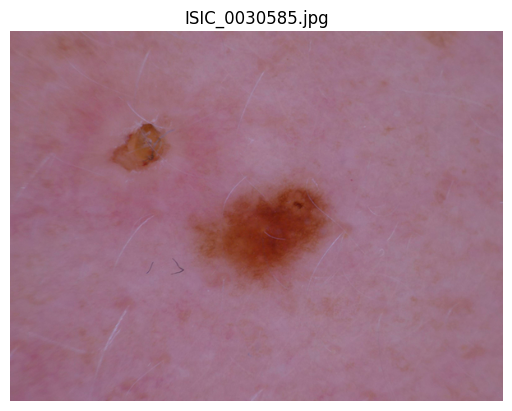

Found image: ISIC_0028394.jpg


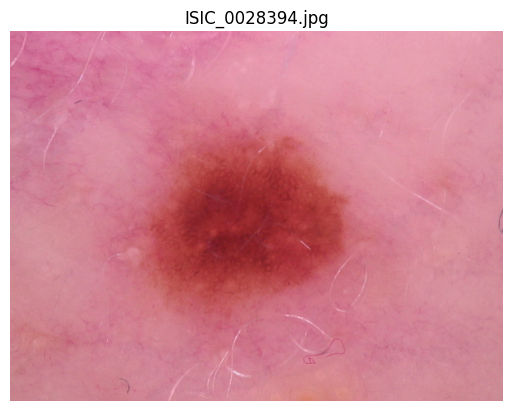

Found image: ISIC_0033697.jpg


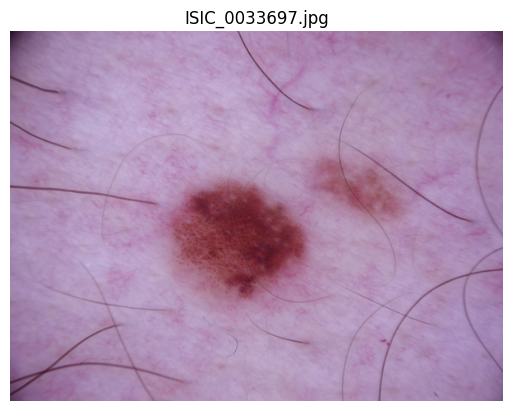

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# List all files in the directory
files = os.listdir(image_folder_path)

# Initialize a counter
image_count = 0

# Iterate over each file and limit to 5 images
for file_name in files:
    # Construct the full file path
    file_path = os.path.join(image_folder_path, file_name)

    # Check if the file is an image (assuming common formats like JPEG or PNG)
    if file_path.lower().endswith(('.jpg')):
        # Print the image file name
        print(f"Found image: {file_name}")

        # Open and optionally display the image (optional, for visualization)
        image = Image.open(file_path)
        plt.imshow(image)
        plt.title(file_name)
        plt.axis('off')  # Hide axes
        plt.show()

        # Increment the counter
        image_count += 1

        # Break the loop after 5 images
        if image_count >= 5:
            break


In [5]:
class dataset(Dataset):
    def __init__(self,image_folder_path,transform = None):
        self.image_folder_path = image_folder_path
        self.transform = transform
        self.image_files=[]
        
        for file_name in os.listdir(image_folder_path):
            if file_name.lower().endswith(('.jpg')):
                self.image_files.append(file_name)
                
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx =idx.item()
            
        img_path = os.path.join(self.image_folder_path,self.image_files[idx]) 
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image    

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Data augmentation
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize with mean 0.5, std 0.5
])

In [7]:
custom_dataset = dataset(image_folder_path, transform=transform)
data_loader = DataLoader(custom_dataset, batch_size=8, shuffle=True)

In [8]:
custom_dataset[2].shape

torch.Size([3, 128, 128])

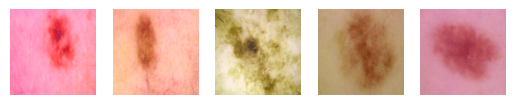

In [9]:
for images in data_loader:
    # Take a few images to display
    batch_images = images[:5]
    for i, img in enumerate(batch_images):
        img = img.permute(1, 2, 0)  
        img = (img + 1) / 2  
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    break  # D

In [10]:
# all_pixels = []

# # Iterate over the data loader to extract all pixel values
# for data in data_loader:
#     # Flatten the tensor to a 1D array and append to the list
#     all_pixels.extend(data.view(-1).numpy())

# # Convert the list of all pixel values to a NumPy array
# all_pixels = np.array(all_pixels)

# # Calculate the variance of the pixel values
# data_variance = np.var(all_pixels)

# print("Data Variance:", data_variance)

In [11]:
data_variance = 0.14623214

In [12]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings,encoding_indices

In [13]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings,encoding_indices

In [14]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [15]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [16]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [17]:
batch_size = 256


num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [18]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ ,_= self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity,quantized

In [19]:
modelv = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [20]:
optimizer = optim.Adam(modelv.parameters(), lr=learning_rate, amsgrad=False)

In [21]:
import wandb

In [23]:
wandb.init()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1, Batch 100:
  Recon Error: 0.132
  Perplexity: 1.000

Epoch 1, Batch 200:
  Recon Error: 0.121
  Perplexity: 1.000

Epoch 1, Batch 300:
  Recon Error: 0.120
  Perplexity: 1.000

Epoch 1, Batch 400:
  Recon Error: 0.115
  Perplexity: 1.000

Epoch 1, Batch 500:
  Recon Error: 0.117
  Perplexity: 1.000

Epoch 1, Batch 600:
  Recon Error: 0.127
  Perplexity: 1.021

Epoch 1, Batch 700:
  Recon Error: 0.109
  Perplexity: 1.499

Epoch 1, Batch 800:
  Recon Error: 0.050
  Perplexity: 2.447

Epoch 1, Batch 900:
  Recon Error: 0.031
  Perplexity: 3.848

Epoch 1, Batch 1000:
  Recon Error: 0.028
  Perplexity: 5.272

Epoch 1, Batch 1100:
  Recon Error: 0.025
  Perplexity: 6.246

Epoch 1, Batch 1200:
  Recon Error: 0.024
  Perplexity: 6.557



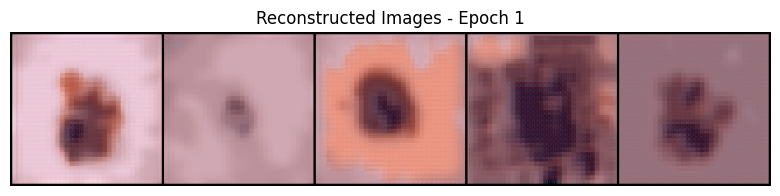

End of Epoch 1:
  Average Recon Error: 0.081
  Average Perplexity: 2.843

Epoch 2, Batch 100:
  Recon Error: 0.018
  Perplexity: 8.945

Epoch 2, Batch 200:
  Recon Error: 0.015
  Perplexity: 10.819

Epoch 2, Batch 300:
  Recon Error: 0.015
  Perplexity: 10.824

Epoch 2, Batch 400:
  Recon Error: 0.014
  Perplexity: 10.898

Epoch 2, Batch 500:
  Recon Error: 0.013
  Perplexity: 10.802

Epoch 2, Batch 600:
  Recon Error: 0.013
  Perplexity: 10.882

Epoch 2, Batch 700:
  Recon Error: 0.013
  Perplexity: 10.642

Epoch 2, Batch 800:
  Recon Error: 0.013
  Perplexity: 10.858

Epoch 2, Batch 900:
  Recon Error: 0.012
  Perplexity: 10.401

Epoch 2, Batch 1000:
  Recon Error: 0.013
  Perplexity: 10.377

Epoch 2, Batch 1100:
  Recon Error: 0.012
  Perplexity: 10.556

Epoch 2, Batch 1200:
  Recon Error: 0.012
  Perplexity: 10.427



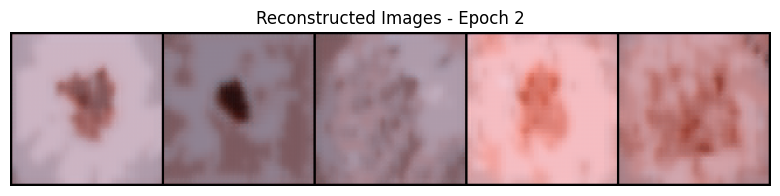

End of Epoch 2:
  Average Recon Error: 0.047
  Average Perplexity: 6.684

Epoch 3, Batch 100:
  Recon Error: 0.012
  Perplexity: 10.461

Epoch 3, Batch 200:
  Recon Error: 0.012
  Perplexity: 10.099

Epoch 3, Batch 300:
  Recon Error: 0.012
  Perplexity: 10.384

Epoch 3, Batch 400:
  Recon Error: 0.012
  Perplexity: 11.635

Epoch 3, Batch 500:
  Recon Error: 0.012
  Perplexity: 12.644

Epoch 3, Batch 600:
  Recon Error: 0.011
  Perplexity: 13.658

Epoch 3, Batch 700:
  Recon Error: 0.010
  Perplexity: 13.466

Epoch 3, Batch 800:
  Recon Error: 0.011
  Perplexity: 13.499

Epoch 3, Batch 900:
  Recon Error: 0.011
  Perplexity: 13.378

Epoch 3, Batch 1000:
  Recon Error: 0.011
  Perplexity: 13.195

Epoch 3, Batch 1100:
  Recon Error: 0.011
  Perplexity: 13.311

Epoch 3, Batch 1200:
  Recon Error: 0.010
  Perplexity: 13.463



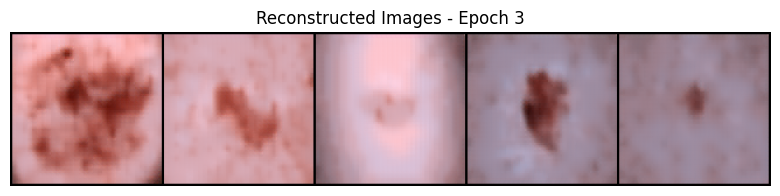

End of Epoch 3:
  Average Recon Error: 0.035
  Average Perplexity: 8.622

Epoch 4, Batch 100:
  Recon Error: 0.010
  Perplexity: 14.361

Epoch 4, Batch 200:
  Recon Error: 0.010
  Perplexity: 15.272

Epoch 4, Batch 300:
  Recon Error: 0.010
  Perplexity: 14.991

Epoch 4, Batch 400:
  Recon Error: 0.009
  Perplexity: 15.453

Epoch 4, Batch 500:
  Recon Error: 0.010
  Perplexity: 15.388

Epoch 4, Batch 600:
  Recon Error: 0.009
  Perplexity: 15.646

Epoch 4, Batch 700:
  Recon Error: 0.009
  Perplexity: 15.494

Epoch 4, Batch 800:
  Recon Error: 0.009
  Perplexity: 15.691

Epoch 4, Batch 900:
  Recon Error: 0.009
  Perplexity: 15.483

Epoch 4, Batch 1000:
  Recon Error: 0.009
  Perplexity: 15.775

Epoch 4, Batch 1100:
  Recon Error: 0.008
  Perplexity: 16.027

Epoch 4, Batch 1200:
  Recon Error: 0.010
  Perplexity: 15.861



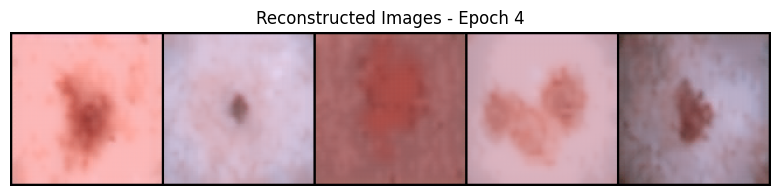

End of Epoch 4:
  Average Recon Error: 0.029
  Average Perplexity: 10.332

Epoch 5, Batch 100:
  Recon Error: 0.010
  Perplexity: 15.952

Epoch 5, Batch 200:
  Recon Error: 0.009
  Perplexity: 16.051

Epoch 5, Batch 300:
  Recon Error: 0.009
  Perplexity: 16.194

Epoch 5, Batch 400:
  Recon Error: 0.009
  Perplexity: 16.143

Epoch 5, Batch 500:
  Recon Error: 0.009
  Perplexity: 15.945

Epoch 5, Batch 600:
  Recon Error: 0.009
  Perplexity: 15.762

Epoch 5, Batch 700:
  Recon Error: 0.009
  Perplexity: 16.982

Epoch 5, Batch 800:
  Recon Error: 0.009
  Perplexity: 17.193

Epoch 5, Batch 900:
  Recon Error: 0.009
  Perplexity: 17.475

Epoch 5, Batch 1000:
  Recon Error: 0.009
  Perplexity: 17.512

Epoch 5, Batch 1100:
  Recon Error: 0.009
  Perplexity: 18.821

Epoch 5, Batch 1200:
  Recon Error: 0.009
  Perplexity: 18.432



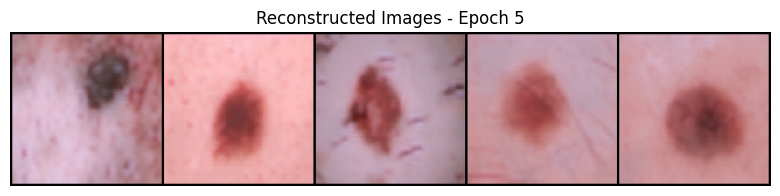

End of Epoch 5:
  Average Recon Error: 0.025
  Average Perplexity: 11.658

Epoch 6, Batch 100:
  Recon Error: 0.008
  Perplexity: 19.535

Epoch 6, Batch 200:
  Recon Error: 0.009
  Perplexity: 20.381

Epoch 6, Batch 300:
  Recon Error: 0.008
  Perplexity: 21.083

Epoch 6, Batch 400:
  Recon Error: 0.007
  Perplexity: 22.746

Epoch 6, Batch 500:
  Recon Error: 0.006
  Perplexity: 23.820

Epoch 6, Batch 600:
  Recon Error: 0.006
  Perplexity: 25.680

Epoch 6, Batch 700:
  Recon Error: 0.006
  Perplexity: 25.132

Epoch 6, Batch 800:
  Recon Error: 0.005
  Perplexity: 24.973

Epoch 6, Batch 900:
  Recon Error: 0.005
  Perplexity: 25.847

Epoch 6, Batch 1000:
  Recon Error: 0.004
  Perplexity: 26.991

Epoch 6, Batch 1100:
  Recon Error: 0.004
  Perplexity: 27.319

Epoch 6, Batch 1200:
  Recon Error: 0.004
  Perplexity: 26.930



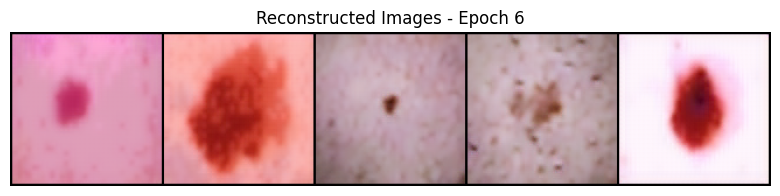

End of Epoch 6:
  Average Recon Error: 0.022
  Average Perplexity: 13.771

Epoch 7, Batch 100:
  Recon Error: 0.004
  Perplexity: 27.009

Epoch 7, Batch 200:
  Recon Error: 0.004
  Perplexity: 27.876

Epoch 7, Batch 300:
  Recon Error: 0.004
  Perplexity: 27.876

Epoch 7, Batch 400:
  Recon Error: 0.004
  Perplexity: 28.304

Epoch 7, Batch 500:
  Recon Error: 0.004
  Perplexity: 28.842

Epoch 7, Batch 600:
  Recon Error: 0.004
  Perplexity: 28.373

Epoch 7, Batch 700:
  Recon Error: 0.004
  Perplexity: 29.483

Epoch 7, Batch 800:
  Recon Error: 0.004
  Perplexity: 29.896

Epoch 7, Batch 900:
  Recon Error: 0.004
  Perplexity: 30.605

Epoch 7, Batch 1000:
  Recon Error: 0.004
  Perplexity: 30.695

Epoch 7, Batch 1100:
  Recon Error: 0.003
  Perplexity: 31.093

Epoch 7, Batch 1200:
  Recon Error: 0.003
  Perplexity: 32.256



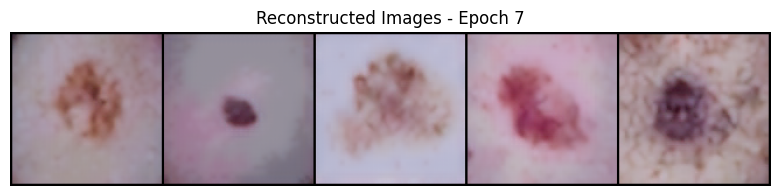

End of Epoch 7:
  Average Recon Error: 0.019
  Average Perplexity: 16.005

Epoch 8, Batch 100:
  Recon Error: 0.003
  Perplexity: 32.875

Epoch 8, Batch 200:
  Recon Error: 0.003
  Perplexity: 31.230

Epoch 8, Batch 300:
  Recon Error: 0.003
  Perplexity: 32.883

Epoch 8, Batch 400:
  Recon Error: 0.003
  Perplexity: 33.048

Epoch 8, Batch 500:
  Recon Error: 0.003
  Perplexity: 33.675

Epoch 8, Batch 600:
  Recon Error: 0.003
  Perplexity: 34.050

Epoch 8, Batch 700:
  Recon Error: 0.003
  Perplexity: 34.731

Epoch 8, Batch 800:
  Recon Error: 0.003
  Perplexity: 34.635

Epoch 8, Batch 900:
  Recon Error: 0.003
  Perplexity: 34.490

Epoch 8, Batch 1000:
  Recon Error: 0.003
  Perplexity: 34.960

Epoch 8, Batch 1100:
  Recon Error: 0.003
  Perplexity: 35.699

Epoch 8, Batch 1200:
  Recon Error: 0.003
  Perplexity: 34.808



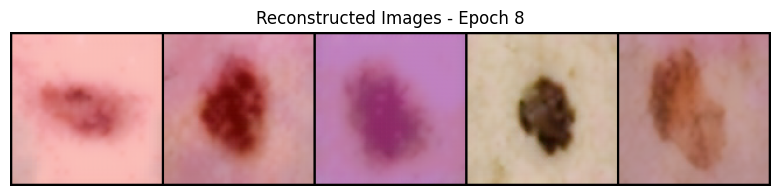

End of Epoch 8:
  Average Recon Error: 0.017
  Average Perplexity: 18.268

Epoch 9, Batch 100:
  Recon Error: 0.003
  Perplexity: 36.449

Epoch 9, Batch 200:
  Recon Error: 0.003
  Perplexity: 37.483

Epoch 9, Batch 300:
  Recon Error: 0.003
  Perplexity: 38.103

Epoch 9, Batch 400:
  Recon Error: 0.003
  Perplexity: 37.559

Epoch 9, Batch 500:
  Recon Error: 0.003
  Perplexity: 38.239

Epoch 9, Batch 600:
  Recon Error: 0.003
  Perplexity: 37.357

Epoch 9, Batch 700:
  Recon Error: 0.003
  Perplexity: 38.767

Epoch 9, Batch 800:
  Recon Error: 0.003
  Perplexity: 38.421

Epoch 9, Batch 900:
  Recon Error: 0.003
  Perplexity: 39.038

Epoch 9, Batch 1000:
  Recon Error: 0.003
  Perplexity: 38.451

Epoch 9, Batch 1100:
  Recon Error: 0.003
  Perplexity: 38.377

Epoch 9, Batch 1200:
  Recon Error: 0.003
  Perplexity: 38.919



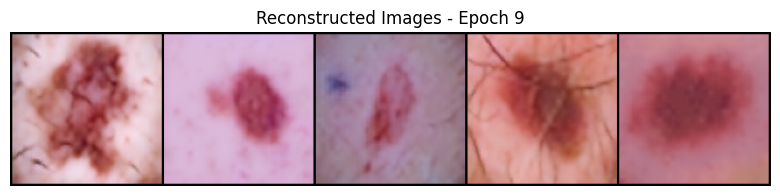

End of Epoch 9:
  Average Recon Error: 0.016
  Average Perplexity: 20.472

Epoch 10, Batch 100:
  Recon Error: 0.003
  Perplexity: 39.079

Epoch 10, Batch 200:
  Recon Error: 0.003
  Perplexity: 39.974

Epoch 10, Batch 300:
  Recon Error: 0.003
  Perplexity: 40.968

Epoch 10, Batch 400:
  Recon Error: 0.003
  Perplexity: 41.269

Epoch 10, Batch 500:
  Recon Error: 0.003
  Perplexity: 41.793

Epoch 10, Batch 600:
  Recon Error: 0.002
  Perplexity: 41.701

Epoch 10, Batch 700:
  Recon Error: 0.002
  Perplexity: 42.591

Epoch 10, Batch 800:
  Recon Error: 0.002
  Perplexity: 43.372

Epoch 10, Batch 900:
  Recon Error: 0.002
  Perplexity: 42.725

Epoch 10, Batch 1000:
  Recon Error: 0.003
  Perplexity: 43.749

Epoch 10, Batch 1100:
  Recon Error: 0.003
  Perplexity: 43.656

Epoch 10, Batch 1200:
  Recon Error: 0.002
  Perplexity: 43.557



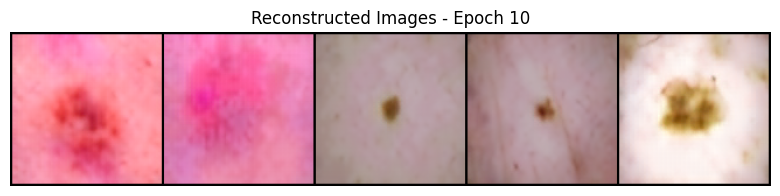

End of Epoch 10:
  Average Recon Error: 0.014
  Average Perplexity: 22.623



In [24]:
train_res_recon_error = []
train_res_perplexity = []
last_reconstructed_images = None  # Placeholder for storing the last reconstructed images

# Mean and standard deviation used for denormalization
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Function to denormalize images
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1)  # Adjust to the shape of the image
    std = torch.tensor(std).view(1, -1, 1, 1)  # Adjust to the shape of the image
    return image * std + mean

# Training loop for 15 epochs
for epoch in range(10):
    # Set the model to training mode
    modelv.train()
    
    # Iterate over the DataLoader
    for batch_idx, data in enumerate(data_loader):
        images = data.to(device)  # Move data to the correct device
        
        optimizer.zero_grad()  # Reset gradients
        
        # Forward pass through the model
        vq_loss, data_recon, perplexity,_ = modelv(images)  
        
        # Calculate reconstruction error
        recon_error = F.mse_loss(data_recon, images)
        
        # Compute the loss and perform backward pass
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()
        
        # Record the metrics to wandb
        wandb.log({
            "recon_error": recon_error.item(),
            "vq_loss": vq_loss.item(),
            "perplexity": perplexity.item()
        })
        
        # Record the metrics
        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        
        # Store the last reconstructed images for visualization
        last_reconstructed_images = data_recon.detach().cpu()  # Detach and move to CPU
        
        # Log information every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}:")
            print(f"  Recon Error: {np.mean(train_res_recon_error[-100:]):.3f}")
            print(f"  Perplexity: {np.mean(train_res_perplexity[-100:]):.3f}\n")
    
    # Denormalize and visualize the last reconstructed images at the end of each epoch
    if last_reconstructed_images is not None:
        denorm_images = denormalize(last_reconstructed_images, mean, std)
        grid = make_grid(denorm_images[:5], nrow=5)  # Create a grid of the images
        plt.figure(figsize=(10, 2))
        plt.imshow(grid.permute(1, 2, 0))  # Change tensor to (H, W, C) for visualization
        plt.axis("off")  # Hide axis
        plt.title(f"Reconstructed Images - Epoch {epoch + 1}")
        plt.show()
    
    # Additional epoch-level logging
    print(f"End of Epoch {epoch + 1}:")
    print(f"  Average Recon Error: {np.mean(train_res_recon_error):.3f}")
    print(f"  Average Perplexity: {np.mean(train_res_perplexity):.3f}\n")
    
    
wandb.finish()

In [26]:
torch.save(modelv.state_dict(), '/kaggle/working/vq_vae_model.pth')

# Or save individual components
torch.save(modelv._encoder.state_dict(), '/kaggle/working/encoder.pth')
torch.save(modelv._pre_vq_conv.state_dict(), '/kaggle/working/prevqconv.pth')
torch.save(modelv._vq_vae.state_dict(), '/kaggle/working/prevq.pth')
torch.save(modelv._decoder.state_dict(), '/kaggle/working/decoder.pth')

In [27]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

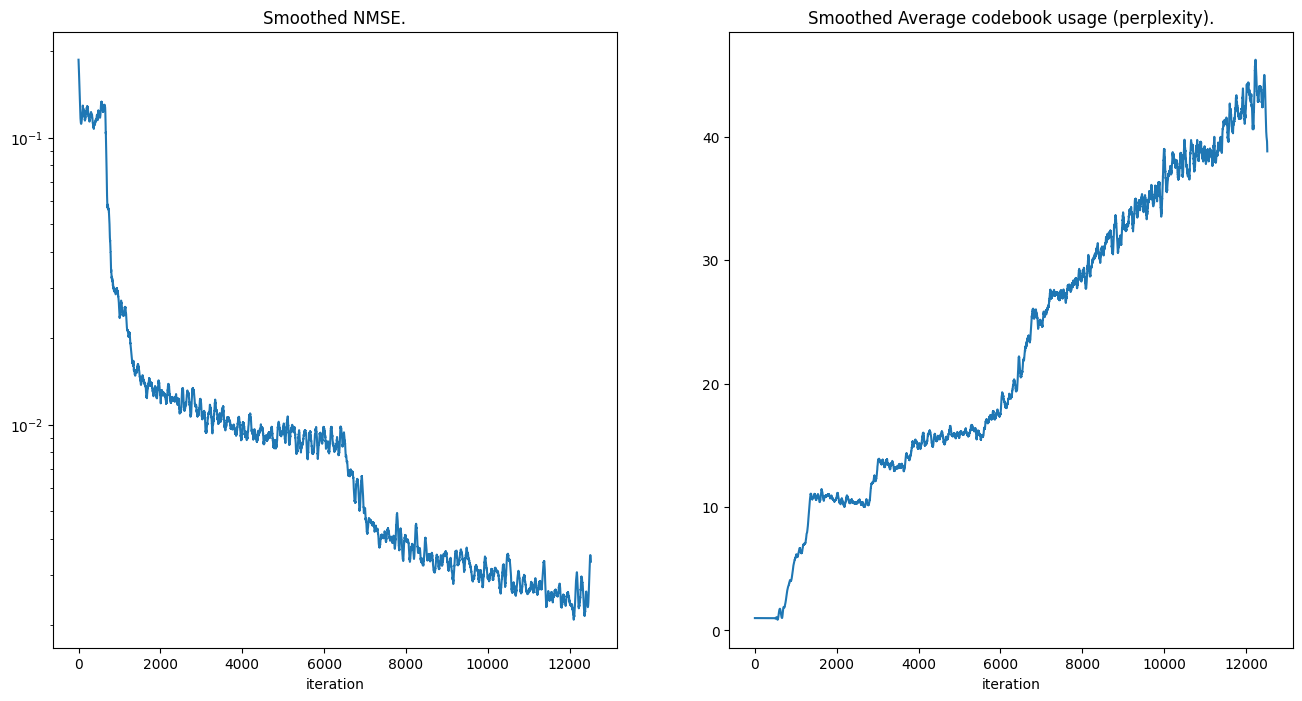

In [28]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [32]:
modelv.eval()

valid_originals = next(iter(data_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = modelv._pre_vq_conv(modelv._encoder(valid_originals))
loss, valid_quantize, perplexity, _ ,_ = modelv._vq_vae(vq_output_eval)
valid_reconstructions = modelv._decoder(valid_quantize)

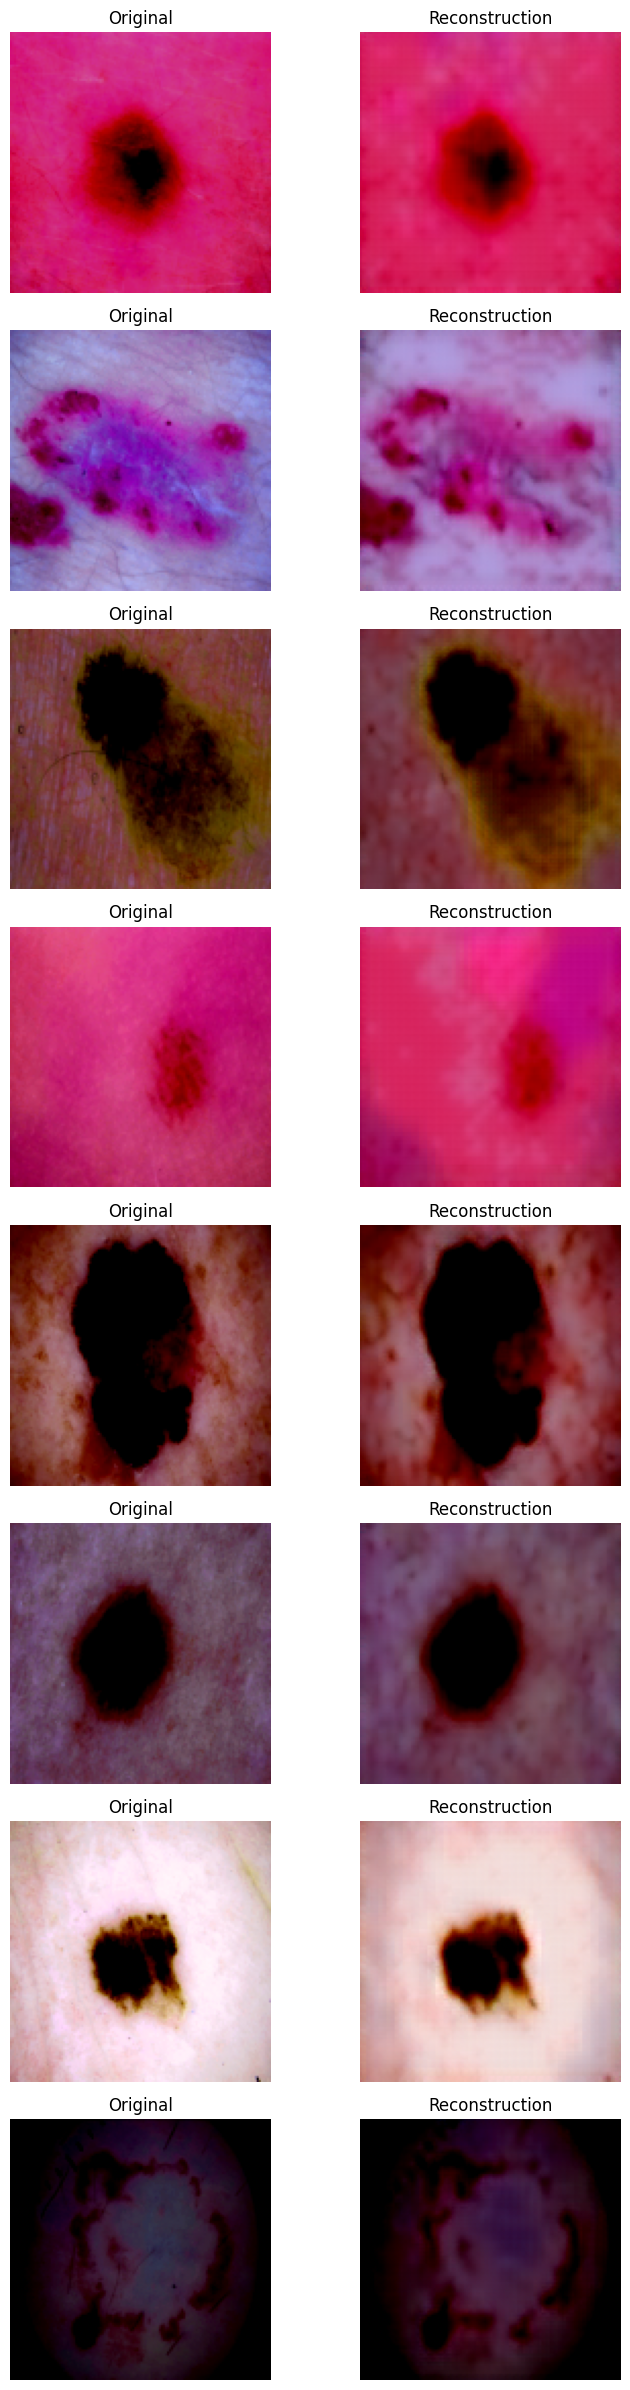

In [38]:
import matplotlib.pyplot as plt

# Plot originals and reconstructions side by side for each image
num_images = len(valid_originals)
fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(8, 3*num_images))

for i in range(num_images):
    original_img = valid_originals[i].cpu().permute(1, 2, 0)
    reconstruction_img = valid_reconstructions[i].detach().cpu().permute(1, 2, 0)

    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstruction_img)
    axes[i, 1].set_title("Reconstruction")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

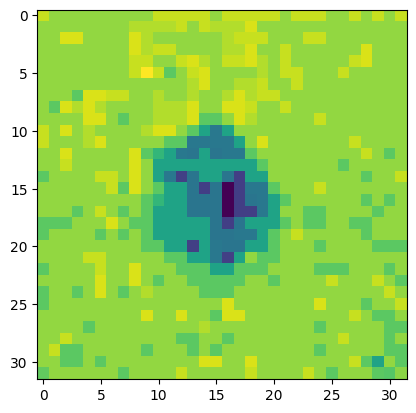

In [48]:
valid_quantize_cpu = valid_quantize.cpu()
valid_quantize_np = valid_quantize_cpu.detach().numpy()
plt.imshow(valid_quantize_np.reshape(-1, 32, 32)[5])
plt.show()

In [49]:
# custom_dataset = dataset(image_folder_path, transform=transform)
# new_loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)

In [50]:
# quantised_list = []

# # Loop over the DataLoader to extract indices with the trained VQ-VAE
# with torch.no_grad():
#     for images in new_loader:
#         # Move images to the appropriate device
#         images = images.to(device)

#         # Get the quantized output from the VQ-VAE model
#         _, _, _, quantised = modelv(images)

#         # If `quantised` is a tuple, access the correct tensor
#         if isinstance(quantised, tuple):
#             quantised = quantised[1]  # Adjust as necessary

#         # Loop over each item in the batch to add individually
#         for item in quantised:
#             # Ensure it's a tensor and convert to NumPy
#             quantised_numpy = item.cpu().numpy()

#             # Append the reshaped individual output
#             quantised_list.append(quantised_numpy)


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
import pandas as pd

In [52]:
label = pd.read_csv("/kaggle/input/isci-cgan-dataset/Dataset/Train/Train_labels.csv")
label_csv_path = "/kaggle/input/isci-cgan-dataset/Dataset/Train/Train_labels.csv"

In [53]:
label

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0      ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1      ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2      ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3      ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4      ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
...             ...  ...  ...  ...    ...  ...  ...   ...
10010  ISIC_0034316  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10011  ISIC_0034317  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10012  ISIC_0034318  0.0  0.0  0.0    0.0  1.0  0.0   0.0
10013  ISIC_0034319  0.0  1.0  0.0    0.0  0.0  0.0   0.0
10014  ISIC_0034320  0.0  1.0  0.0    0.0  0.0  0.0   0.0

[10015 rows x 8 columns]

In [54]:
class CustomDataset(Dataset):
    def __init__(self, image_folder_path, label_csv_path, transform=None):
        self.image_folder_path = image_folder_path
        self.label_csv_path = label_csv_path
        self.transform = transform
        self.data = pd.read_csv(label_csv_path)  # Assuming labels are stored in a CSV file
        self.image_files = [file for file in os.listdir(image_folder_path) if file.lower().endswith(('.jpg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        img_path = os.path.join(self.image_folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        # Convert one-hot encoded labels to the desired form
        label = torch.tensor(self.data.iloc[idx, 1:].values.argmax())  # Assumes labels start from column index 1

        if self.transform:
            image = self.transform(image)

        return image, label


In [55]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Data augmentation
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize with mean 0.5, std 0.5
])

In [56]:
custom_dataset = CustomDataset(image_folder_path,label_csv_path, transform=transform)
data_loader = DataLoader(custom_dataset, batch_size=8, shuffle=True)

In [57]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)



class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, n_classes=7):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual

        self.class_cond_embedding = nn.Embedding(
            n_classes, 2 * dim
        )

        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()

        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h

In [58]:
class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=7):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, n_classes)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        # print(shp)
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        # print(x.shape)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, H)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, shape=(8, 8), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                probs = F.softmax(logits[:, :, i, j], -1)
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [59]:
n_embeddings=512
img_dim=8
n_layers=15
prior = GatedPixelCNN(n_embeddings, img_dim**2, n_layers).to(device)
criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(prior.parameters(), lr=3e-4)

Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


In [62]:
from tqdm import tqdm

def train():
    train_loss = 0
    # Wrap data_loader with tqdm for progress bar
    for batch_idx, (x, label) in tqdm(enumerate(data_loader), total=len(data_loader)):
        bs = x.size(0)
        vq_output_eval = modelv._pre_vq_conv(modelv._encoder(x.to(device)))
        _, _, _, _, x = modelv._vq_vae(vq_output_eval)
        x = (x[:, 0]).long()
        x = x.view(bs, 32, 32)
        label = label.to(device)
           
        # Train PixelCNN with images
        logits = prior(x, label)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        loss = criterion(logits.view(-1, n_embeddings), x.view(-1))

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()
        
        # Log training loss to wandb
        wandb.log({"train_loss": loss.item()})
    
    return train_loss / len(data_loader)

In [61]:
wandb.init()

wandb: Currently logged in as: gyanendrachaubey (gyanendrachaubeyproject). Use `wandb login --relogin` to force relogin


In [63]:
epochs=20
for epoch in range(epochs):
  train_loss = train()
  print('epoch: {}/{}, Train loss: {:.6f}'.format(epoch+1, epochs, train_loss))
wandb.finish()

100%|██████████| 1252/1252 [03:29<00:00,  5.98it/s]


epoch: 1/20, Train loss: 2.163552


100%|██████████| 1252/1252 [03:22<00:00,  6.18it/s]


epoch: 2/20, Train loss: 1.772108


100%|██████████| 1252/1252 [03:19<00:00,  6.27it/s]


epoch: 3/20, Train loss: 1.730325


100%|██████████| 1252/1252 [03:21<00:00,  6.22it/s]


epoch: 4/20, Train loss: 1.705945


100%|██████████| 1252/1252 [03:21<00:00,  6.21it/s]


epoch: 5/20, Train loss: 1.686178


100%|██████████| 1252/1252 [03:20<00:00,  6.23it/s]


epoch: 6/20, Train loss: 1.676741


100%|██████████| 1252/1252 [03:19<00:00,  6.26it/s]


epoch: 7/20, Train loss: 1.666003


100%|██████████| 1252/1252 [03:20<00:00,  6.26it/s]


epoch: 8/20, Train loss: 1.655263


100%|██████████| 1252/1252 [03:20<00:00,  6.23it/s]


epoch: 9/20, Train loss: 1.647588


100%|██████████| 1252/1252 [03:19<00:00,  6.26it/s]


epoch: 10/20, Train loss: 1.636590


100%|██████████| 1252/1252 [03:21<00:00,  6.23it/s]


epoch: 11/20, Train loss: 1.631279


100%|██████████| 1252/1252 [03:22<00:00,  6.18it/s]


epoch: 12/20, Train loss: 1.625971


100%|██████████| 1252/1252 [03:22<00:00,  6.19it/s]


epoch: 13/20, Train loss: 1.623368


100%|██████████| 1252/1252 [03:19<00:00,  6.26it/s]


epoch: 14/20, Train loss: 1.616171


100%|██████████| 1252/1252 [03:19<00:00,  6.27it/s]


epoch: 15/20, Train loss: 1.613042


100%|██████████| 1252/1252 [03:19<00:00,  6.28it/s]


epoch: 16/20, Train loss: 1.607047


100%|██████████| 1252/1252 [03:19<00:00,  6.29it/s]


epoch: 17/20, Train loss: 1.605820


100%|██████████| 1252/1252 [03:19<00:00,  6.29it/s]


epoch: 18/20, Train loss: 1.604613


100%|██████████| 1252/1252 [03:19<00:00,  6.27it/s]


epoch: 19/20, Train loss: 1.602190


100%|██████████| 1252/1252 [03:20<00:00,  6.25it/s]


epoch: 20/20, Train loss: 1.595875


In [78]:
def generate_samples():
    label = torch.arange(10).expand(4, 10).contiguous().view(-1)
    label = label.long().cuda()
    bs = 40
    num_embeddings=512
    shape=(8,8)
    x_q = prior.generate(label, shape=(8,8), batch_size=bs)
    x_q = x_q.view(-1,1)
    encodings = torch.zeros(x_q.shape[0], num_embeddings, device=x_q.device)
    encodings.scatter_(1, x_q, 1)

    embed_weight = modelv._vq_vae._embedding.weight
    quantized = torch.matmul(encodings, embed_weight).view(bs,*shape,-1)
    quantized = quantized.permute(0,3,1,2).contiguous()

    x_recon = modelv._decoder(quantized)


    # print(x_tilde[0])
    return x_recon, label

out, label = generate_samples()

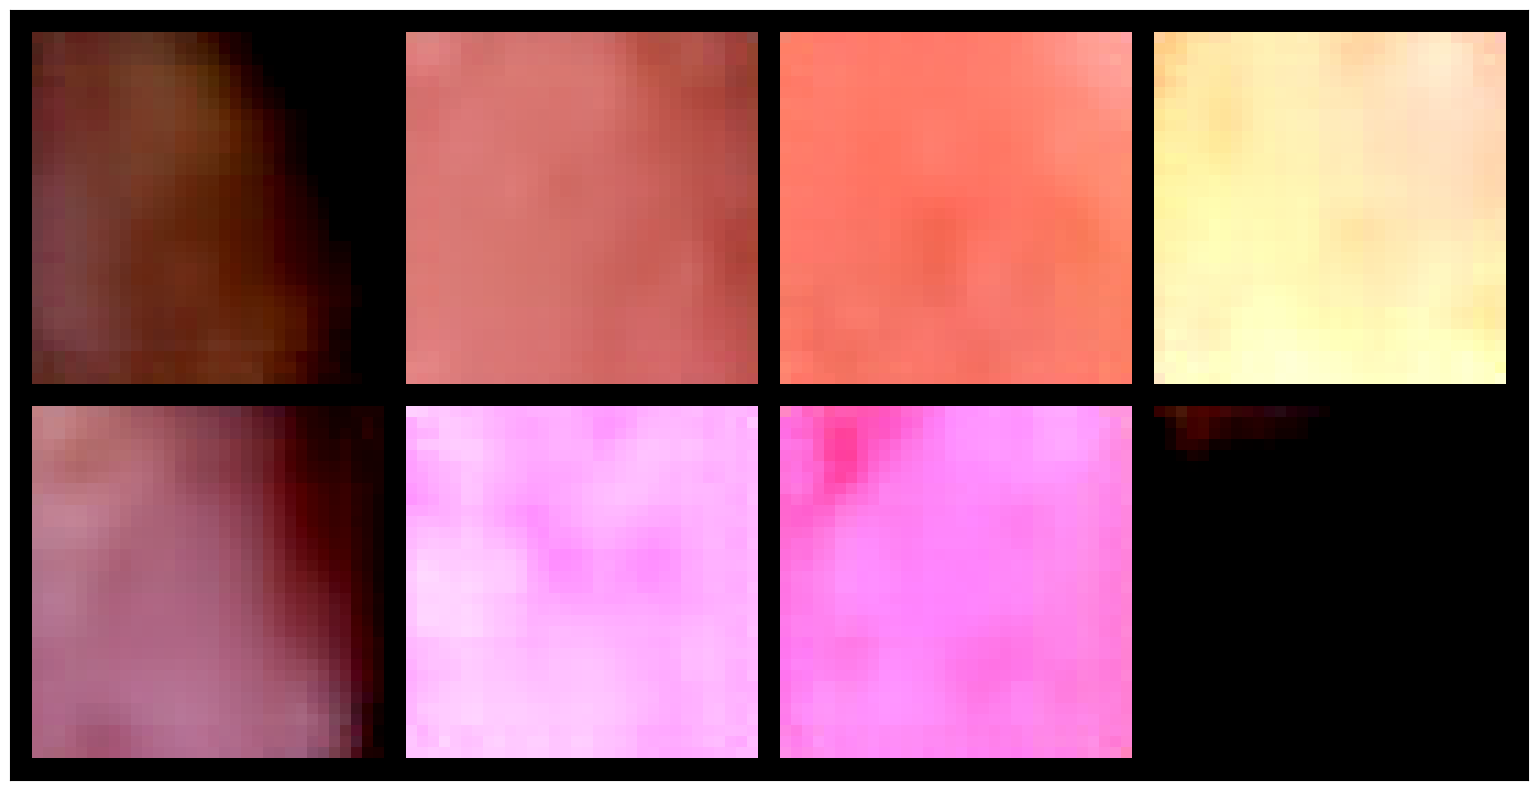

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

# Assuming out is a tensor containing generated images
show(make_grid(out[:8].detach().cpu() + 0.5, nrow=4))